Машины опорных векторов (сокращенно SVM) — это контролируемые алгоритмы машинного обучения, которые используются для целей классификации и регрессии. В этом задании вам необходимо обучить Support Vector Machines для классификации пульсаров. 


**1. Прочитайте данные, сделайте беглый EDA - посмотрите на кол-во данных, названия столбцов, нет ли в них ошибок, переименуйте для более удобной работы, есть ли пропущенные значения. Посмотрите нет ли дисбаланса классов по таргету? Сделайте саммари по признакам. Отобразите боксплоты признаков, чтобы оценить выбросы в данных. Постройте гистограммы признаков, чтобы взглянуть на распределение данных.**

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv('pulsar_data_train.csv')
new_names = {' Mean of the integrated profile': 'prof_mean',
             ' Standard deviation of the integrated profile': 'prof_std',
             ' Excess kurtosis of the integrated profile': 'prof_excess',
             ' Skewness of the integrated profile': 'prof_skew', 
             ' Mean of the DM-SNR curve': 'curv_mean',
             ' Standard deviation of the DM-SNR curve': 'curv_std',
             ' Excess kurtosis of the DM-SNR curve': 'curv_excess', 
             ' Skewness of the DM-SNR curve': 'curv_skew',
             'target_class': 'target'}
df = df.rename(columns=new_names)
df.head(5)

,prof_mean,prof_std,prof_excess,prof_skew,curv_mean,curv_std,curv_excess,curv_skew,target
0,121.156250,48.372971,0.375485,-0.013165,3.168896,18.399367,7.449874,65.159298,0.0
1,76.968750,36.175557,0.712898,3.388719,2.399666,17.570997,9.414652,102.722975,0.0
2,130.585938,53.229534,0.133408,-0.297242,2.743311,22.362553,8.508364,74.031324,0.0
3,156.398438,48.865942,-0.215989,-0.171294,17.471572,NaN,2.958066,7.197842,0.0
4,84.804688,36.117659,0.825013,3.274125,2.790134,20.618009,8.405008,76.291128,0.0


In [3]:
df_info = df.describe()
df_info

,prof_mean,prof_std,prof_excess,prof_skew,curv_mean,curv_std,curv_excess,curv_skew,target
count,12528.000000,12528.000000,10793.000000,12528.000000,12528.000000,11350.000000,12528.000000,11903.000000,12528.000000
mean,111.041841,46.521437,0.478548,1.778431,12.674758,26.351318,8.333489,105.525779,0.092034
std,25.672828,6.801077,1.064708,6.208450,29.613230,19.610842,4.535783,107.399585,0.289085
min,5.812500,24.772042,-1.738021,-1.791886,0.213211,7.370432,-3.139270,-1.976976,0.000000
25%,100.871094,42.362222,0.024652,-0.188142,1.910535,14.404353,5.803063,35.199899,0.000000
50%,115.183594,46.931022,0.223678,0.203317,2.792642,18.412402,8.451097,83.126301,0.000000
75%,127.109375,50.979103,0.473125,0.932374,5.413253,28.337418,10.727927,139.997850,0.000000
max,189.734375,91.808628,8.069522,68.101622,222.421405,110.642211,34.539844,1191.000837,1.000000


In [5]:
# выбросы 
def is_eject(names, values):
    result = False
    for pair in zip(names, values):
        name, x = pair
        x_mean, x_std = df_info.loc['mean'][name], df_info.loc['std'][name]
        result = abs(x - x_mean) > 2 * x_std
        if result:
            return result
    return result

col_names = df.columns.tolist()[:-1]

df['is_eject'] = False


df['is_eject'] = df.loc[:, col_names].apply(lambda x: is_eject(col_names, x), axis=1)

print(df['is_eject'].unique())


[False  True]


In [6]:
df[df['is_eject']].shape

(2476, 10)

In [7]:
print(df.shape)
df.isnull().sum()


(12528, 10)


prof_mean         0
prof_std          0
prof_excess    1735
prof_skew         0
curv_mean         0
curv_std       1178
curv_excess       0
curv_skew       625
target            0
is_eject          0
dtype: int64

<AxesSubplot:>

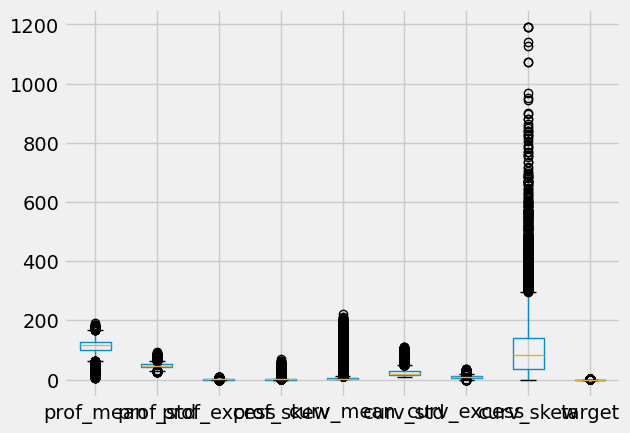

In [9]:
df_this = pd.DataFrame(data=df, columns=col_names)
df_this.boxplot()

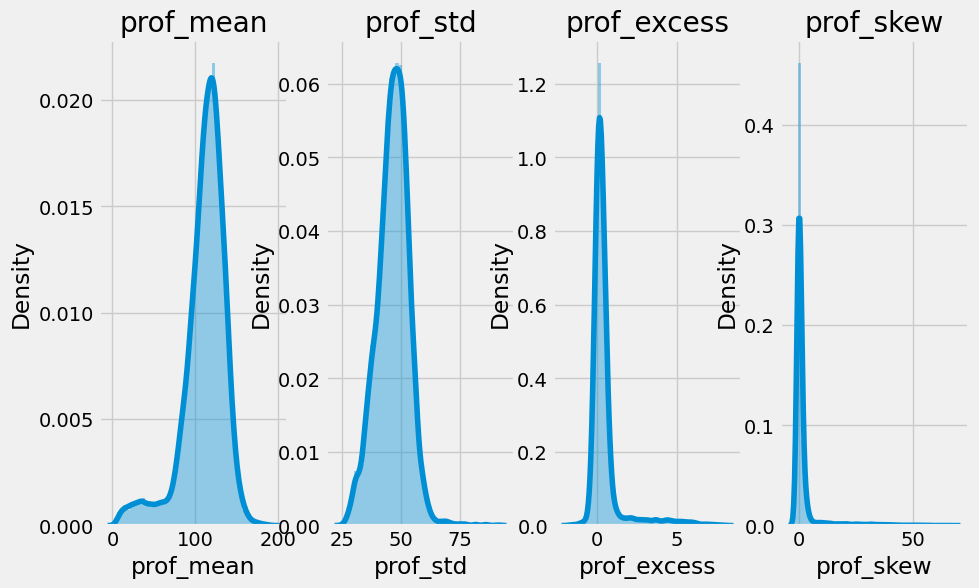

In [10]:
# for key in ['prof_mean', 'prof_std', 'prof_excess', 'prof_skew', 'curv_mean',
#        'curv_std', 'curv_excess', 'curv_skew']:

f,ax=plt.subplots(1,4, figsize=(10,6))
for i, k in enumerate(['prof_mean', 'prof_std', 'prof_excess', 'prof_skew']):
    sns.distplot(df[k], ax=ax[i])
    ax[i].set_title(k)

plt.show()

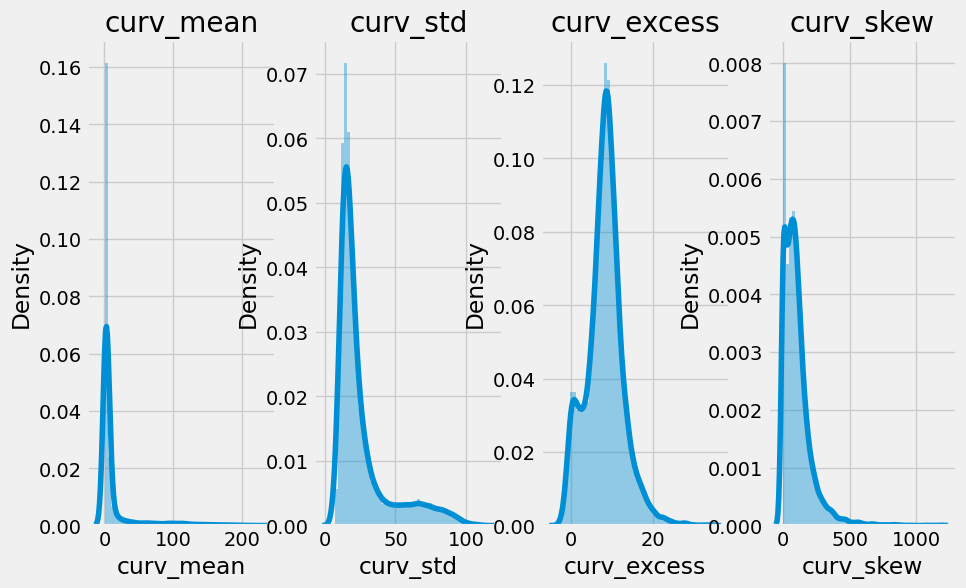

In [11]:
f,ax=plt.subplots(1,4, figsize=(10,6))
for i, k in enumerate(['curv_mean', 'curv_std', 'curv_excess', 'curv_skew']):
    sns.distplot(df[k], ax=ax[i])
    ax[i].set_title(k)

plt.show()

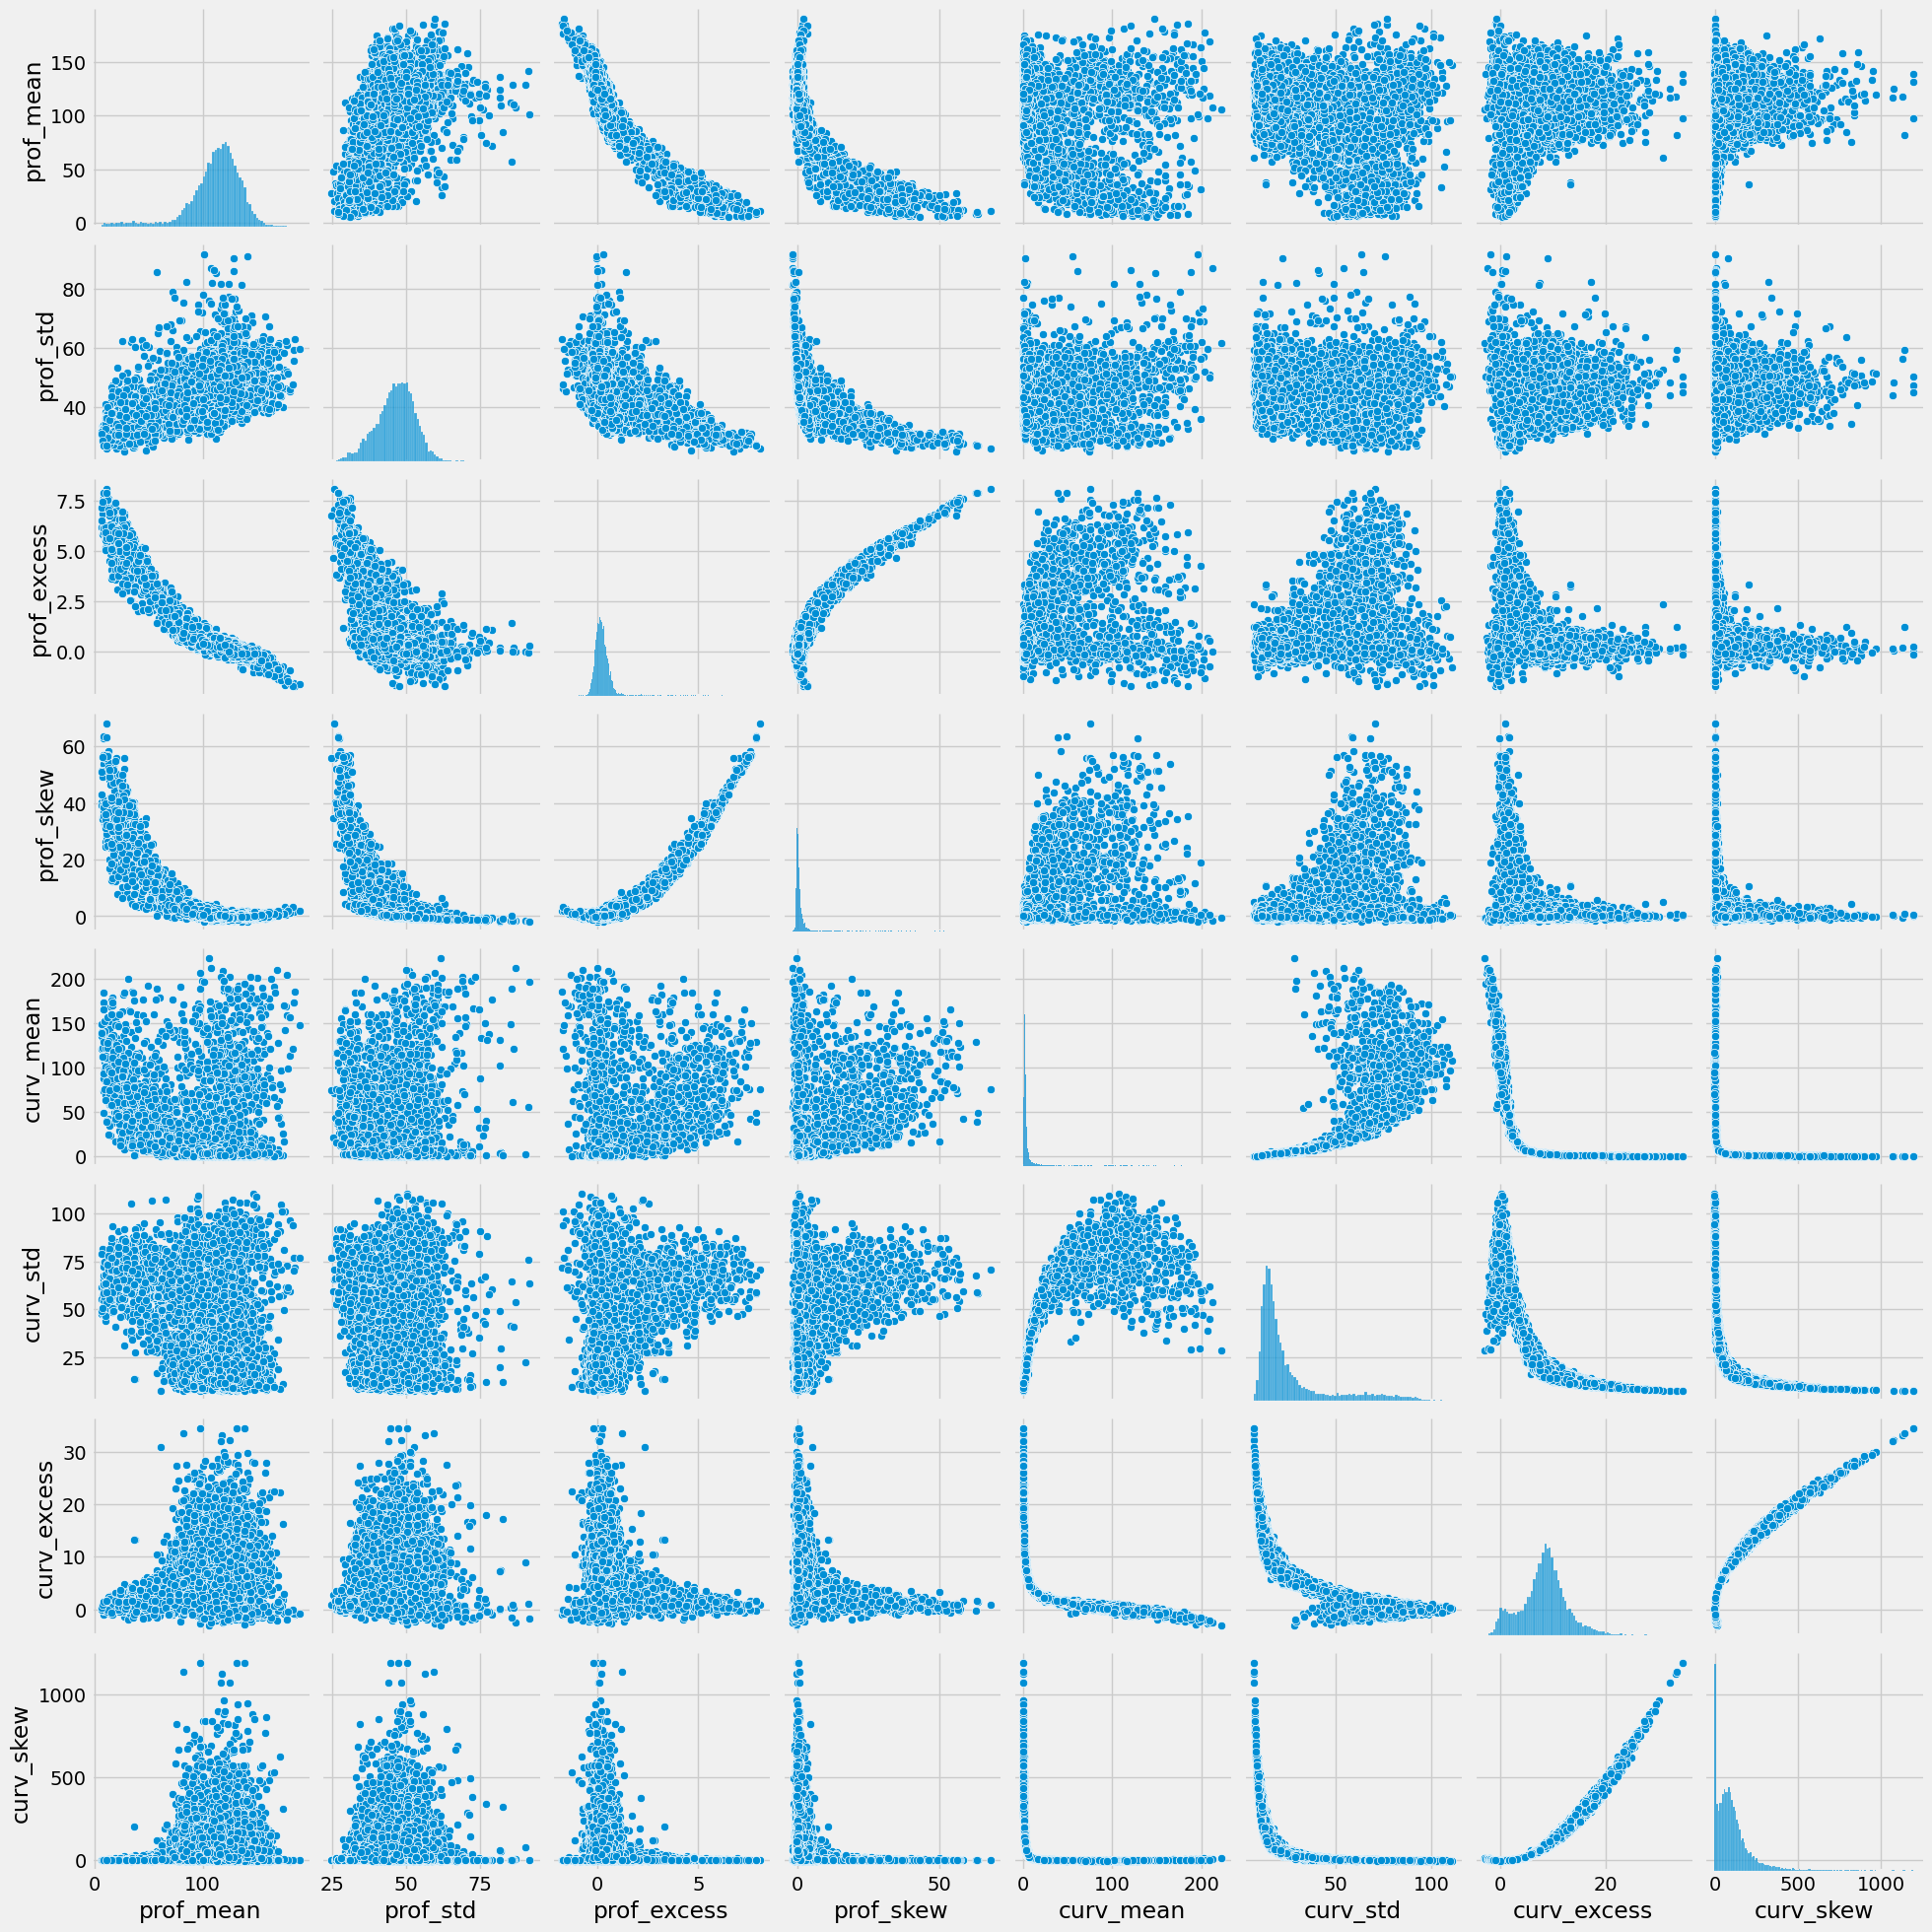

In [12]:
selected = df.loc[:, ['prof_mean', 'prof_std', 'prof_excess', 'prof_skew', 'curv_mean',
       'curv_std', 'curv_excess', 'curv_skew']]
sns.pairplot(selected) 
plt.show()

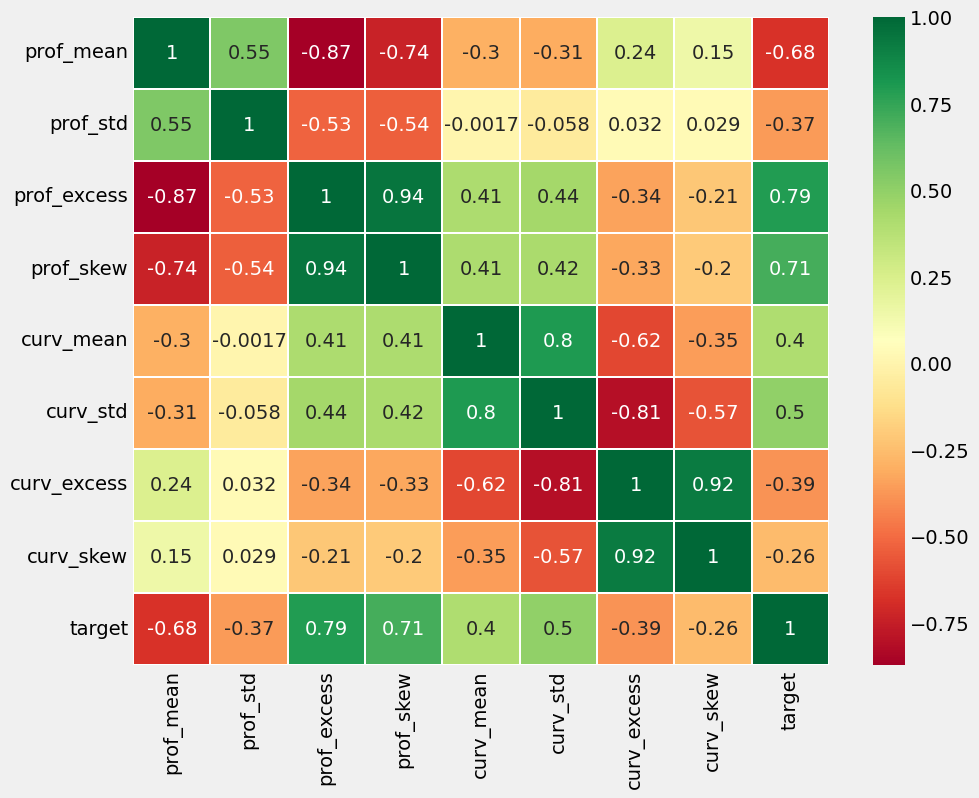

In [13]:
df_this = df.loc[:, col_names]  
sns.heatmap(df_this.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show() 

In [14]:
# надо восстановить nan  в prof_excess, curv_std, curv_skew  

from sklearn.impute import KNNImputer

#определяем импортер
imputer=KNNImputer(n_neighbors=5, weights='uniform')

new_df = df[~df['is_eject']].copy(deep = True)
  
new_df.isnull().sum()

prof_mean         0
prof_std          0
prof_excess    1395
prof_skew         0
curv_mean         0
curv_std        965
curv_excess       0
curv_skew       496
target            0
is_eject          0
dtype: int64

In [15]:
#устанавливаем импортер на датасет без выбросов

imputer.fit(new_df)

# восстанавливаем данные

new_df_1 = imputer.transform(df)

# полученные данные преобразовываем в DataFrame

myImputer_data = pd.DataFrame(new_df_1,columns = new_df.columns)
myImputer_data.isnull().sum()

prof_mean      0
prof_std       0
prof_excess    0
prof_skew      0
curv_mean      0
curv_std       0
curv_excess    0
curv_skew      0
target         0
is_eject       0
dtype: int64

Text(0, 0.5, 'curv_std')

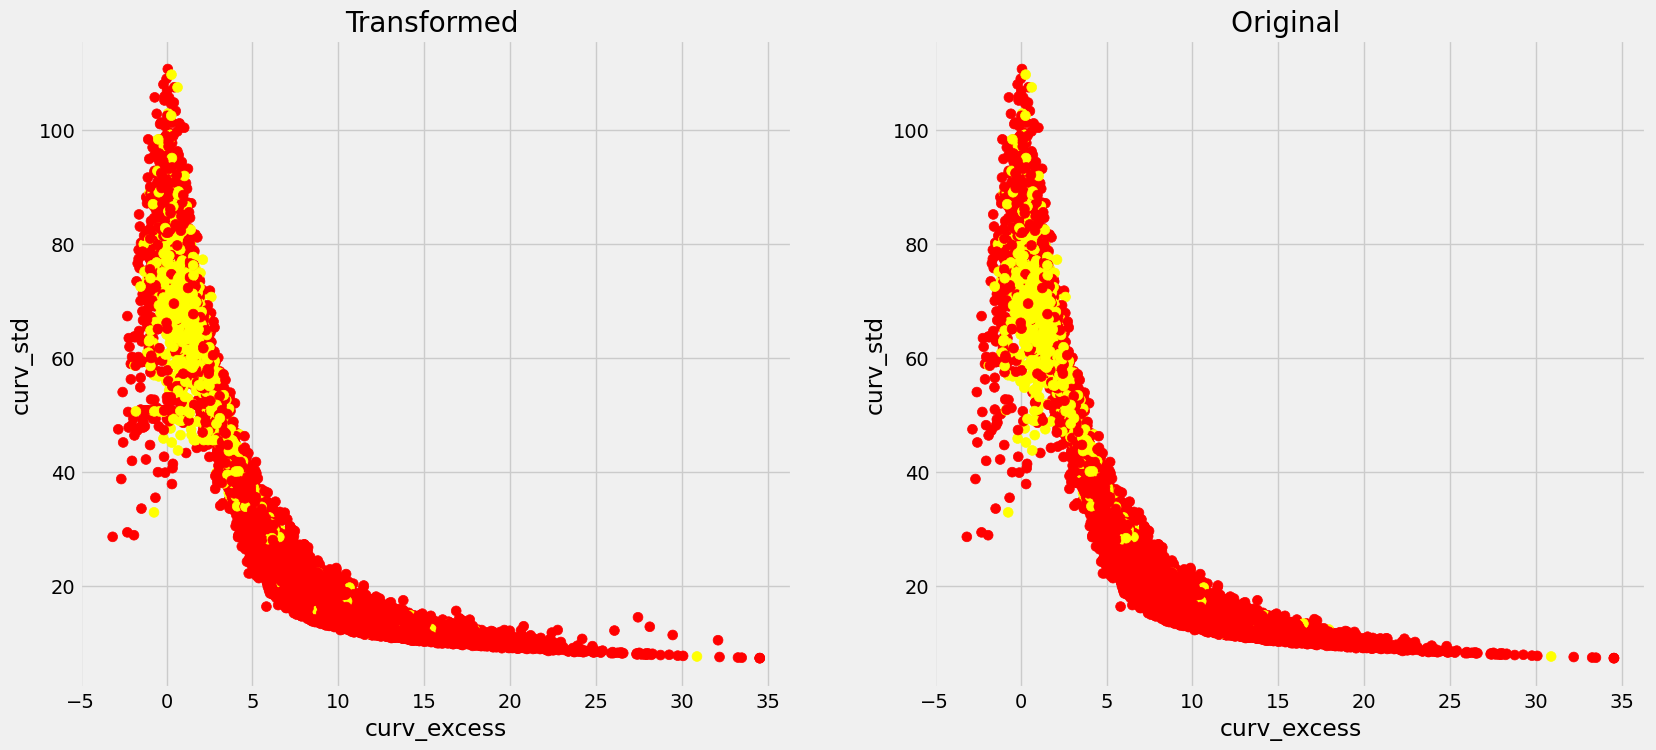

In [16]:
# ну что, вроде прилично
f,ax=plt.subplots(1,2,figsize=(18,8))
# plt.scatter(myImputer_data['curv_excess'], myImputer_data['curv_std'], 
#             c=myImputer_data['target'], s=50, cmap='autumn')
ax[0].scatter(myImputer_data['curv_excess'], myImputer_data['curv_std'], 
            c=myImputer_data['target'], s=50, cmap='autumn')
ax[0].set_title('Transformed ')
ax[0].set_xlabel('curv_excess')
ax[0].set_ylabel('curv_std')
ax[1].scatter(df['curv_excess'], df['curv_std'], 
            c=df['target'], s=50, cmap='autumn')
ax[1].set_title('Original ')
ax[1].set_xlabel('curv_excess')
ax[1].set_ylabel('curv_std')

In [17]:
# дисбаланс по классам - 1 в 10 раз меньше чем 0

myImputer_data[myImputer_data['target'] == 0.].shape, myImputer_data[myImputer_data['target'] == 1.].shape

((11375, 10), (1153, 10))

In [100]:
from sklearn.utils import resample
df_major = myImputer_data[myImputer_data.target == 0]
df_minor = myImputer_data[myImputer_data.target == 1]
#Resampling
df_major_sample = resample(df_major,  replace=True, n_samples=2000, random_state=42)
#df_minor_sample = resample(df_minor,  replace=True, n_samples=5000, random_state=42)

df_sample = pd.concat([df_major_sample, df_minor])
print(df_sample.target.value_counts())

0.0    2000
1.0    1153
Name: target, dtype: int64


Text(0, 0.5, 'curv_std')

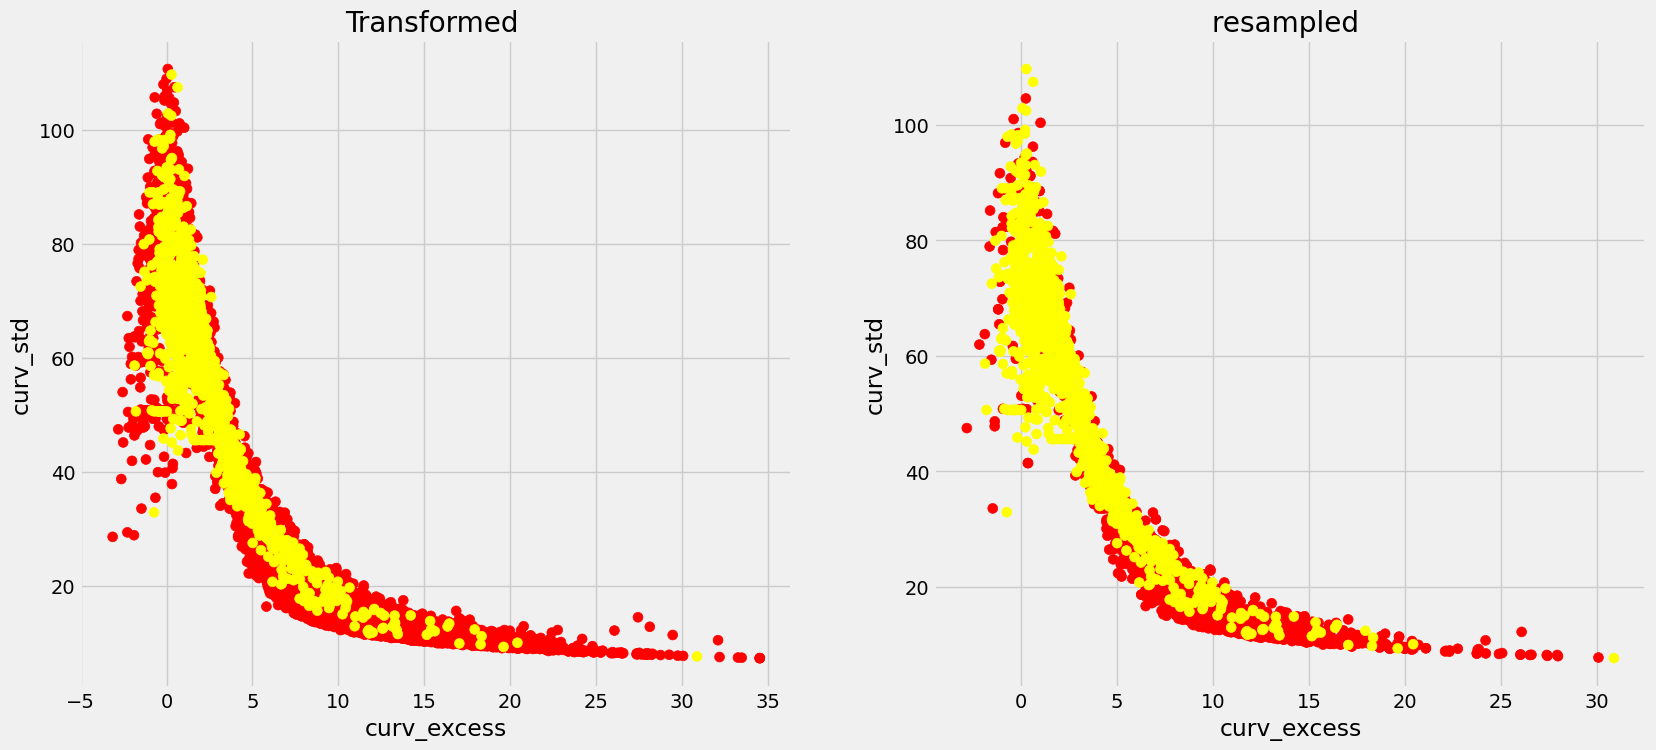

In [101]:
f,ax=plt.subplots(1,2,figsize=(18,8))
# plt.scatter(myImputer_data['curv_excess'], myImputer_data['curv_std'], 
#             c=myImputer_data['target'], s=50, cmap='autumn')
temp = pd.concat([df_major, df_minor])
ax[0].scatter(temp['curv_excess'], temp['curv_std'], 
            c=temp['target'], s=50, cmap='autumn')
ax[0].set_title('Transformed ')
ax[0].set_xlabel('curv_excess')
ax[0].set_ylabel('curv_std')
ax[1].scatter(df_sample['curv_excess'], df_sample['curv_std'], 
            c=df_sample['target'], s=50, cmap='autumn')
ax[1].set_title('resampled ')
ax[1].set_xlabel('curv_excess')
ax[1].set_ylabel('curv_std')

**2. Определите матрицу признаков и переменную таргета. Разделите трейновый набор трейн и тест с помощью train_test_split. Зафиксируйте размер тестовой выборки 0.2, а рэндом стэйт равный 0.** 

In [151]:
from sklearn.model_selection import train_test_split
features = ['prof_mean',
 'prof_std',
 'prof_excess',
 'prof_skew',
 'curv_mean',
 'curv_std',
 'curv_excess',
 'curv_skew']
X = df_sample.loc[:, features]
y = df_sample['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X.columns

Index(['prof_mean', 'prof_std', 'prof_excess', 'prof_skew', 'curv_mean',
       'curv_std', 'curv_excess', 'curv_skew'],
      dtype='object')

**3. Используя StandartScaler отмасштабируйте матрицу признаков трейн и тест.**

In [152]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [154]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


**4. Обучите SVM Classifier на данных используя GridSearchCV: Попробуйте разные значения С, типа ядер, а так же значение гамма для rbf ядра. Подберите правильную метрику для оценки качества алгоритма. Убедитесь, что значения на тестровой и трейновой выборке сопоставимы и модель не переобучилась.**

In [156]:
model = SVC()
param_grid = {'kernel': ['rbf', 'linear'], 
              'C': [1, 5, 10, 50],
              'gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(X_train, y_train)

Wall time: 57.6 s


GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 5, 10, 50],
                         'gamma': [0.0001, 0.0005, 0.001, 0.005],
                         'kernel': ['rbf', 'linear']})

In [157]:
grid.best_params_

{'C': 5, 'gamma': 0.0001, 'kernel': 'linear'}

In [158]:
model = grid.best_estimator_
y_predicted = model.predict(X_test)

**5. Постройте confusion_matrix и classification report.**

[Text(0.5, 0, 'Predicted'),
 Text(0, 0.5, 'Actual'),
 Text(0.5, 1.0, 'Confusion Matrix Actual vs Predicted')]

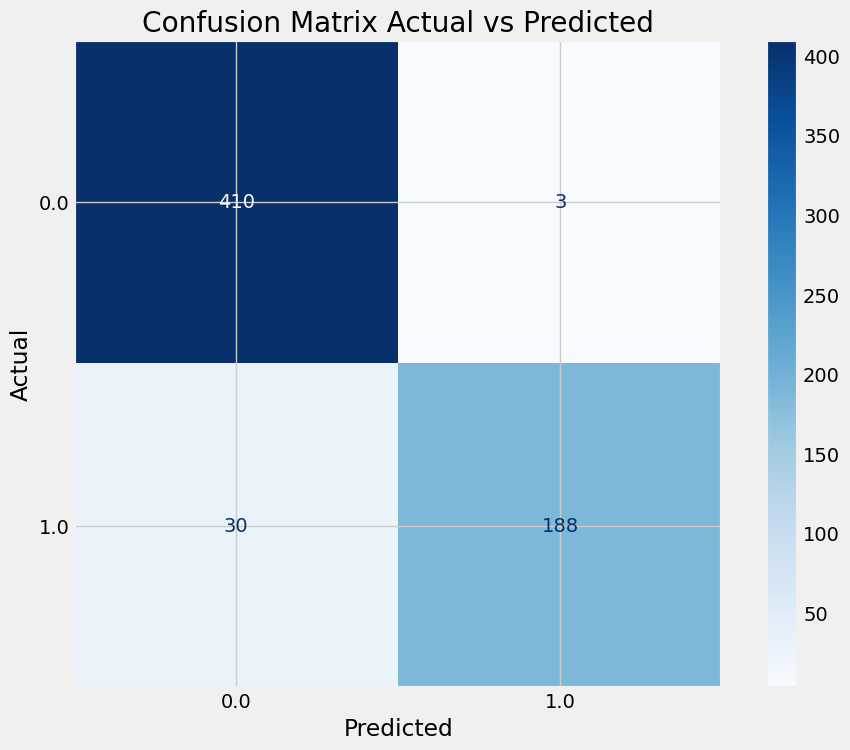

In [159]:
from sklearn import metrics
fig, ax = plt.subplots(figsize=(10,8))
metrics.plot_confusion_matrix(model, X_test, y_test, ax=ax, cmap=plt.cm.Blues)
ax.set(xlabel='Predicted', ylabel='Actual', title='Confusion Matrix Actual vs Predicted')

[Text(0.5, 0, 'Train Predicted'),
 Text(0, 0.5, 'Train Actual'),
 Text(0.5, 1.0, 'Confusion Matrix Actual vs Predicted')]

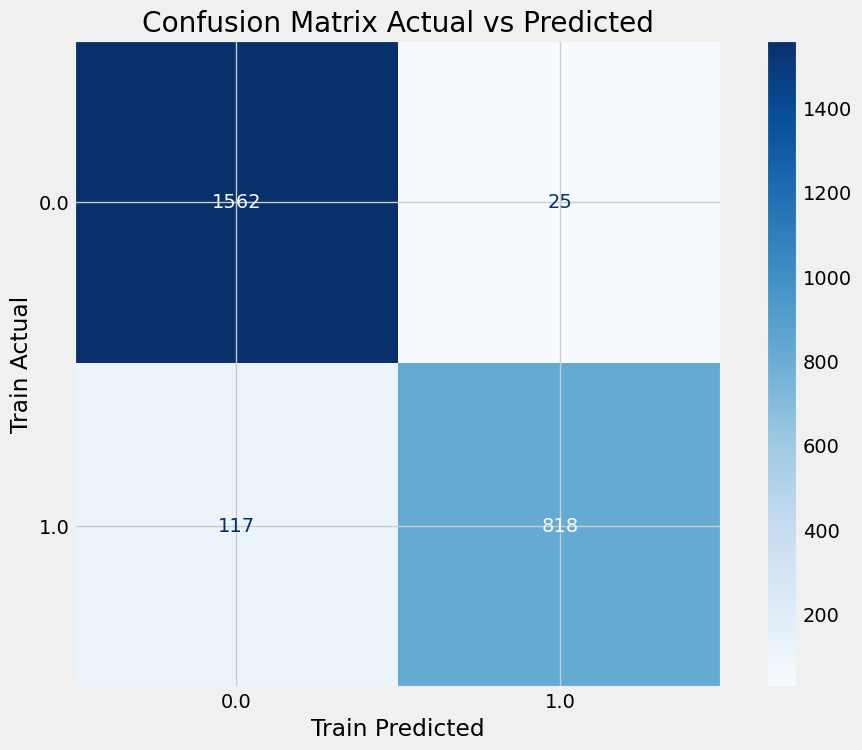

In [160]:
fig, ax = plt.subplots(figsize=(10,8))
metrics.plot_confusion_matrix(model, X_train, y_train, ax=ax, cmap=plt.cm.Blues)
ax.set(xlabel='Train Predicted', ylabel='Train Actual', title='Confusion Matrix Actual vs Predicted')

In [161]:
from sklearn. metrics import classification_report
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96       413
         1.0       0.98      0.86      0.92       218

    accuracy                           0.95       631
   macro avg       0.96      0.93      0.94       631
weighted avg       0.95      0.95      0.95       631



**6. Обучите Decision tree classifier на тех же данных, используя GridSearchCV подберите гиперпараметры для модели. Используйте ту же метрику, что и в задаче с SVM. Убедитесь, что алгоритм не переобучился**

In [165]:
from sklearn.tree import DecisionTreeClassifier
clf_gini = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=0)


# fit the model
clf_gini.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=0)

In [166]:
y_pred_gini = clf_gini.predict(X_test)

**7. Постройте confusion_matrix и classification report.**

[Text(0.5, 0, 'Tree test Predicted'),
 Text(0, 0.5, 'Tree test Actual'),
 Text(0.5, 1.0, 'Confusion Matrix Actual vs Predicted')]

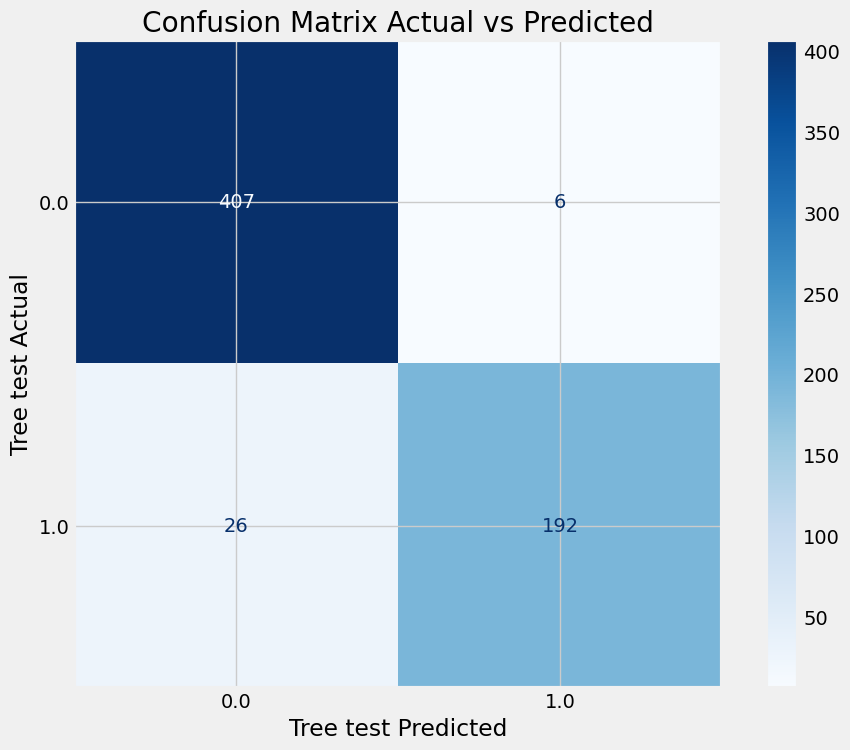

In [167]:
fig, ax = plt.subplots(figsize=(10,8))
metrics.plot_confusion_matrix(clf_gini, X_test, y_test, ax=ax, cmap=plt.cm.Blues)
ax.set(xlabel='Tree test Predicted', ylabel='Tree test Actual', title='Confusion Matrix Actual vs Predicted')

In [164]:
from sklearn. metrics import classification_report
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96       413
         1.0       0.98      0.86      0.92       218

    accuracy                           0.95       631
   macro avg       0.96      0.93      0.94       631
weighted avg       0.95      0.95      0.95       631



**8. Напишите выводы по качеству моделей.**

Качество моделей примерно на одном уровне но вторая модель лучше идентифицирует пульсары, что нам и нужно.